In [3]:
import numpy as np
import xarray as xr
from scipy.io import loadmat 
import gsw
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
from tqdm.notebook import tqdm
import warnings 
warnings.filterwarnings('ignore')

In [3]:
# ARGO density 
f_argo_s = '/Users/jakesteinberg/Documents/CPT/Argo/RG_climatology/RG_ArgoClim_Salinity_2019.nc'
f_argo_t = '/Users/jakesteinberg/Documents/CPT/Argo/RG_climatology/RG_ArgoClim_Temperature_2019.nc'
argo_s = xr.open_dataset(f_argo_s,decode_times=False)
argo_t = xr.open_dataset(f_argo_t,decode_times=False)
A_lon = argo_s.LONGITUDE.data
A_lat = argo_s.LATITUDE.data
# ARGO MLD 
f_argo_mld = '/Users/jakesteinberg/Documents/CPT/Argo/Argo_mixedlayers_monthlyclim_12112019.nc'
argo_mld = xr.open_dataset(f_argo_mld)
mld_lon = argo_mld['lon'].data
mld_lat = argo_mld['lat'].data
mld_mo = argo_mld['month'].data
mld = argo_mld['mld_dt_mean'].data

In [4]:
# A_s = argo_s.ARGO_SALINITY_MEAN + argo_s.ARGO_SALINITY_ANOMALY[0]
# A_t = argo_t.ARGO_TEMPERATURE_MEAN + argo_t.ARGO_TEMPERATURE_ANOMALY[0]

# Argo_s_clim = np.nan*np.ones((12, np.shape(argo_s.ARGO_SALINITY_ANOMALY[0])[0], \
#                               np.shape(argo_s.ARGO_SALINITY_ANOMALY[0])[1], \
#                               np.shape(argo_s.ARGO_SALINITY_ANOMALY[0])[2]))
# Argo_t_clim = np.nan*np.ones((12, np.shape(argo_s.ARGO_SALINITY_ANOMALY[0])[0], \
#                               np.shape(argo_s.ARGO_SALINITY_ANOMALY[0])[1], \
#                               np.shape(argo_s.ARGO_SALINITY_ANOMALY[0])[2]))
# count = 0
# for i in tqdm(np.unique(np.mod(argo_s.ARGO_SALINITY_ANOMALY.TIME.data,12))):
#     this_i = np.where(np.mod(argo_s.ARGO_SALINITY_ANOMALY.TIME.data,12) == i)[0]
#     Argo_s_clim[count] = argo_s.ARGO_SALINITY_MEAN + np.nanmean(argo_s.ARGO_SALINITY_ANOMALY[this_i],axis=0)
#     Argo_t_clim[count] = argo_t.ARGO_TEMPERATURE_MEAN + np.nanmean(argo_t.ARGO_TEMPERATURE_ANOMALY[this_i],axis=0)
#     count = count+1

In [5]:
# how_deep = 30
# density = np.nan * np.ones((12,how_deep,len(A_s.LATITUDE),len(A_s.LONGITUDE)))
# for m in range(12):                                 # month 
#     for i in tqdm(range(len(A_s.LATITUDE))):        # lat
#         for j in range(len(A_s.LONGITUDE)):         # lon
#             for k in range(np.shape(density)[1]):   # depth 
#                 this_p = A_s.PRESSURE[k].data
#                 this_sa = gsw.SA_from_SP(Argo_s_clim[m,k,i,j].data, \
#                                          this_p, A_s.LONGITUDE[j].data, A_s.LATITUDE[i].data)
#                 this_ct = gsw.CT_from_t(this_sa, Argo_t_clim[m,k,i,j].data, this_p)
#                 density[m,k,i,j] = gsw.sigma0(this_sa, this_ct)

In [5]:
# save file 
# -------------------------------
# filename = ('/Users/jakesteinberg/Documents/CPT/Argo/Argo_potential_density_0_400m.nc')
# ds = xr.Dataset(
#     data_vars=dict(
#         density=(["month","pressure","lat","lon"], density),
#     ),
#     coords=dict(
#         pressure=(["pressure"], A_s.PRESSURE[0:hd_pe].data),
#         month=(["month"], np.arange(0,12,1)),
#         latitude=(["lat"], A_s.LATITUDE.data),
#         longitude=(["lon"], A_s.LONGITUDE.data),
#     ),
# )
# ds.to_netcdf(path=filename)

In [6]:
# -- Roemmich and Gilson Argo (load densities ... code to calulate is above) 
filename = ('/Users/jakesteinberg/Documents/CPT/Argo/Argo_potential_density_0_400m.nc')
argo_rho = xr.open_dataset(filename)
density = argo_rho['density'].data
lon = argo_rho.lon.longitude.data
lat = argo_rho.lat.latitude.data
pressure = argo_rho.pressure.pressure.data
# -- USE MIXED LAYER CLIMATOLOGY TO ASK DEPTHS OVER WHICH TO INTEGRATE
f_argo_mld = '/Users/jakesteinberg/Documents/CPT/Argo/Argo_mixedlayers_monthlyclim_12112019.nc'
argo_mld = xr.open_dataset(f_argo_mld)
mld_lon = argo_mld['lon'].data + 200
iinn = np.where((argo_mld['lat'].data >= np.nanmin(lat)) & \
         (argo_mld['lat'].data <= np.nanmax(lat)))[0]
mld_lat = argo_mld['lat'].data[iinn]
mld_offset = np.where(argo_mld['lon'].data >= lon[0])[0][0]
mld = argo_mld['mld_dt_mean'].data[iinn]
mld = np.concatenate((mld[:,mld_offset:,:], mld[:,0:mld_offset,:]),axis=1)

In [4]:
# -- MIMOC 
filename = ('/Users/jakesteinberg/Documents/CPT/Argo/mimoc_potential_density_10m_w_mld.nc')
argo_rho = xr.open_dataset(filename)
density = argo_rho['density'].data
mld = argo_rho['mld'].data
lon = argo_rho.lon.longitude.data
lat = argo_rho.lat.latitude.data

# Argo Climatology (mean seasonal cycle from a ten year time series) 

- compute potential density profiles (0-400m) (referenced to the surface)

$P = - \frac{1}{2}g \int \int \int \frac{\left( \rho - \overline{\rho} \right)^2}{\partial \overline{\rho}/dz} dx dy dz $ ("New Estimates of the Available Potential Energy in the World Ocean" Oort et al. 1989)

### reference profile; easiest is to take a global mean profile
* because this definition uses the square of the density anomaly, low density shallow mixed layers in the western equatorial pacific dominate the PE Map 
* this is a globally defined quantity...distinct from seasonally available PE in the mixed layer
* could define using a local time mean (and still calculate the same way) 

### can adapt this to only calculate PE within the mixed layer (need a MLD criteria...but still a background profile)

In [8]:
how_deep = 30
hd_pe = 30 # decide to what depth we want to integrate PE  
# dz = (-1*A_s.PRESSURE[0:hd_pe-1].data) - (-1*A_s.PRESSURE[1:hd_pe].data)
# dz = np.concatenate((np.array([1*A_s.PRESSURE[0].data]), dz))
dz = (-1*pressure[0:hd_pe-1]) - (-1*pressure[1:hd_pe])
dz = np.concatenate((np.array([1*pressure[0]]), dz))
# -- global mean profile
rho_bar = np.nanmean(np.nanmean( np.nanmean(density,axis=0), axis=1),axis=1)  
# ###### rho_bar_star = np.nanmean(density,axis=0) # mean at one depth 
# -- density anomaly [month, depth, lat, lon]
rho_pr = density - np.tile(rho_bar[None,:,None,None], (12, 1, np.shape(density)[2], np.shape(density)[3]))   
# -- vertical density gradient 
drho_dz = np.nan*np.ones(np.shape(rho_bar))
# drho_dz[1:-1] = (rho_bar[0:-2] - rho_bar[2:])/(-1*(A_s.PRESSURE[0:how_deep-2].data - A_s.PRESSURE[2:how_deep].data))
drho_dz[1:-1] = (rho_bar[0:-2] - rho_bar[2:])/(-1*(pressure[0:how_deep-2] - pressure[2:how_deep]))
drho_dz_map = np.tile(drho_dz[None,:,None,None],(12, 1,np.shape(density)[2], np.shape(density)[3]))
# -- APE 
pe = np.nan * np.ones((12, len(lat), len(lon)))
pe_loc_0 = np.nan * np.ones((12, len(lat), len(lon)))
pe_loc = np.nan * np.ones((12, len(lat), len(lon)))
for i in tqdm(range(np.shape(rho_pr)[0])): # month
    for j in range(np.shape(rho_pr)[2]): # lat
        for k in range(np.shape(rho_pr)[3]): # lon 
            this_mld_z = -1*mld[j,k,i]               # mld of this month
            max_mld_z = -1*np.nanmax(mld[j,k,:])     # deepest mld 
            this_z = gsw.z_from_p(pressure[0:hd_pe],lat[j])
            
            # find deepest z index to start integrating over 
            deep = np.where(this_z <= this_mld_z)[0]
            if max_mld_z < np.nanmin(this_z):
                deep_del = np.array([len(this_z)-1])
            elif max_mld_z > this_z[1]:
                deep_del = np.array([2])
            else:
                deep_del = np.where(this_z <= max_mld_z)[0]
        
            # LOCAL PE 
            # ----------------------------------------------------------------------
            if len(deep_del) > 1: 
                dz2 = (-1*pressure[0:deep_del[0]-1]) - (-1*pressure[1:deep_del[0]])
                dz2 = np.concatenate((np.array([1*pressure[0]]), dz2))
                # - density anomaly relative to profile associated with deepest MLD 
                rho_pr_loc = (density[i,0:deep_del[0],j,k] - \
                    density[np.where(mld[j,k,:] == np.nanmax(mld[j,k,:]))[0],0:deep_del[0],j,k]) 
                # - denominator 
                rho_bar_loc = np.nanmean(density[:,0:deep_del[0],j,k],axis=0)
                drho_bar_dz_loc = np.nan*np.ones(np.shape(rho_bar_loc))
                drho_bar_dz_loc[1:-1] = (rho_bar_loc[0:-2] - rho_bar_loc[2:])/(-1*(pressure[0:deep_del[0]-2] - pressure[2:deep_del[0]]))
                drho_bar_dz_loc[0] = (rho_bar_loc[0] - rho_bar_loc[1])/(-1*(pressure[0] - pressure[1]))
                # - allow vertical density gradient to vary 
                pe_loc_0[i,j,k] = np.nansum((-0.5*9.81*(rho_pr_loc[0,:]**2)/drho_bar_dz_loc)*dz2)
                # - Sylvia's suggestion: N_0, rho_0 are constants 
                rho_0 = 1025
                N_0_2 = (-9.81/rho_0)*np.nanmean(drho_dz[0:10])
                pe_loc[i,j,k] = np.nansum((0.5*(9.81**2)*(rho_pr_loc[0,:]**2)/(rho_0*N_0_2))*dz2)


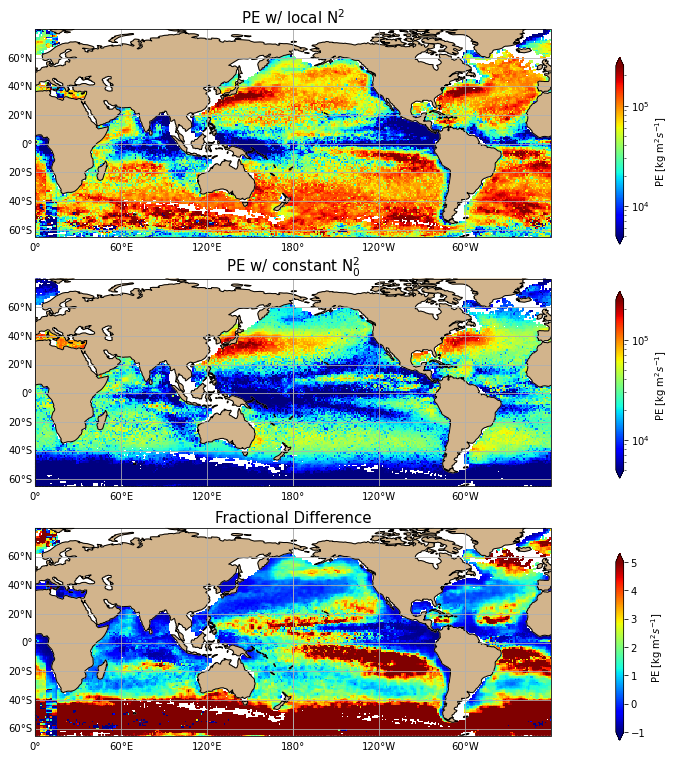

In [13]:
# COMPARE PE LOC ESTIMATES 
data_coords = {'latitude': lat, 'longitude': lon}
pe_levs = [5000, 250000] # 250000
f, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(11,13), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
arg_d = xr.DataArray(data=np.nanmax(pe_loc_0,axis=0), dims=['latitude', 'longitude'], coords=data_coords) 
arg_d_p = arg_d.plot(ax=ax1,transform=ccrs.PlateCarree(), norm=LogNorm(vmin=pe_levs[0], vmax=pe_levs[1]), \
                     cmap=plt.get_cmap('jet'), zorder=0, add_colorbar=False) # norm=LogNorm(vmin=pe_levs[0], vmax=pe_levs[1])
ax1.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax1.coastlines()
gl = ax1.gridlines(draw_labels=True)
ax1.set_title('PE w/ local N$^2$',fontsize=15)
gl.xlabels_top = False
cbpos = [0.92, 0.4, 0.01, 0.2]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_d_p, cax=cax, orientation='vertical', extend='both', label='PE [kg m$^2$$s^{-1}$]')

arg_d = xr.DataArray(data=np.nanmax(pe_loc,axis=0), dims=['latitude', 'longitude'], coords=data_coords) 
arg_d_p = arg_d.plot(ax=ax2,transform=ccrs.PlateCarree(), norm=LogNorm(vmin=pe_levs[0], vmax=pe_levs[1]), \
                     cmap=plt.get_cmap('jet'), zorder=0, add_colorbar=False) # norm=LogNorm(vmin=pe_levs[0], vmax=pe_levs[1])
ax2.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax2.coastlines()
gl = ax2.gridlines(draw_labels=True)
ax2.set_title('PE w/ constant N$_0^2$',fontsize=15)
gl.xlabels_top = False
cbpos = [0.92, 0.65, 0.01, 0.2]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_d_p, cax=cax, orientation='vertical', extend='both', label='PE [kg m$^2$$s^{-1}$]')

arg_d = xr.DataArray(data=(np.nanmax(pe_loc_0,axis=0) - np.nanmax(pe_loc,axis=0))/np.nanmax(pe_loc,axis=0), \
                     dims=['latitude', 'longitude'], coords=data_coords) 
arg_d_p = arg_d.plot(ax=ax3,transform=ccrs.PlateCarree(), vmin=-1, vmax=5, \
                     cmap=plt.get_cmap('jet'), zorder=0, add_colorbar=False) # norm=LogNorm(vmin=pe_levs[0], vmax=pe_levs[1])
ax3.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax3.coastlines()
gl = ax3.gridlines(draw_labels=True)
ax3.set_title('Fractional Difference',fontsize=15)
gl.xlabels_top = False
cbpos = [0.92, 0.12, 0.01, 0.2]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_d_p, cax=cax, orientation='vertical', extend='both', label='PE [kg m$^2$$s^{-1}$]')
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_07_23/argo_mean_pe.jpg', dpi=550)

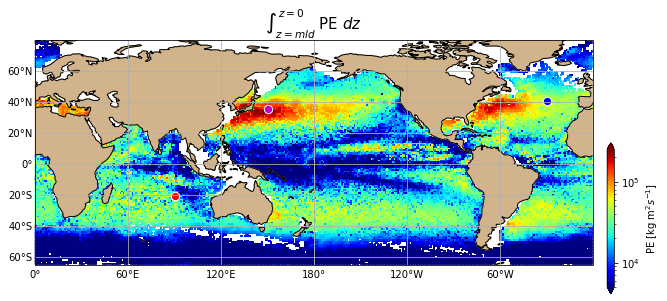

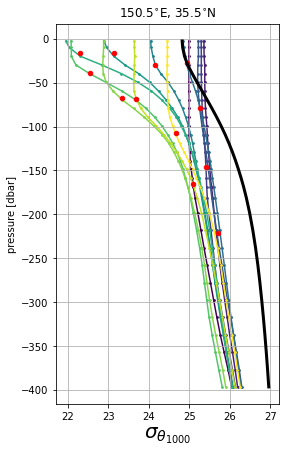

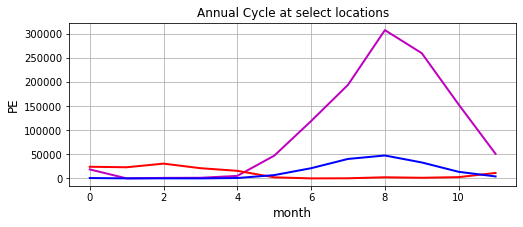

In [9]:
# -- kuroshio
t_lat = 35.5
t_lon = 150.5 
# -- western eq pac 
# t_lat = 10.5
# t_lon = 150.5 
# -- ne pac.
# t_lat = 40.5
# t_lon = 190.5 
# -- site 2 
t_lat_2 = -20.5
t_lon_2 = 90.5 
# -- site 3 
t_lat_3 = 40.5
t_lon_3 = 330.5 

data_coords = {'latitude': lat, 'longitude': lon}
pe_levs = [5000, 250000] # 250000

# FIGURE 1 (map of mean PE)
f, ax = plt.subplots(1,1,figsize=(10,7), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
arg_d = xr.DataArray(data=np.nanmax(pe_loc,axis=0), dims=['latitude', 'longitude'], coords=data_coords)
arg_d_p = arg_d.plot(ax=ax,transform=ccrs.PlateCarree(), norm=LogNorm(vmin=pe_levs[0], vmax=pe_levs[1]), \
                     cmap=plt.get_cmap('jet'), zorder=0, add_colorbar=False)
ax.contour(lon,lat,np.nanmean(pe,axis=0),\
           colors='k',transform=ccrs.PlateCarree(),levels=np.arange(pe_levs[0],pe_levs[1],75000),linewidths=0.5)
ax.scatter(t_lon - 360,t_lat, s=70,color='m',transform=ccrs.PlateCarree(),zorder=2,edgecolors='w')
ax.scatter(t_lon_2, t_lat_2, s=70,color='r',transform=ccrs.PlateCarree(),zorder=2,edgecolors='w')
ax.scatter(t_lon_3, t_lat_3, s=70,color='b',transform=ccrs.PlateCarree(),zorder=2,edgecolors='w')
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
ax.set_title('$\int_{z=mld}^{z=0}$ PE $dz$',fontsize=15)
gl.xlabels_top = False
cbpos = [0.92, 0.222, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_d_p, cax=cax, \
                orientation='vertical', extend='both', \
                label='PE [kg m$^2$$s^{-1}$]')
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_07_23/argo_mean_pe.jpg', dpi=550)

# FIGURE 2 (12 monthly profiles at one select location)
c_eta = plt.get_cmap('viridis',12)
f, ax = plt.subplots(1,1,figsize=(4,7))
for i in range(12):
    this_z = gsw.z_from_p(pressure,t_lat)
    this_lon = np.where((A_lon > (t_lon-0.5)) & (A_lon < (t_lon+0.5)))[0][0]
    this_lat = np.where((A_lat > (t_lat-0.5)) & (A_lat < (t_lat+0.5)))[0][0]
    ax.plot(density[i, :, this_lat, this_lon], this_z[0:how_deep], color=c_eta(i),zorder=0)
    ax.scatter(density[i, :, this_lat, this_lon], this_z[0:how_deep],s=3, color=c_eta(i),zorder=1)
    int_z = -1*mld[this_lat,this_lon,i]
    deep = np.where(this_z <= int_z)[0]
    if len(deep) > 0:
        ax.scatter(density[i, deep[0], this_lat, this_lon],int_z,s=20, color='r',zorder=2)
ax.plot(np.nanmean(np.nanmean( np.nanmean(density,axis=0) ,axis=1),axis=1), this_z[0:how_deep], \
        color='k',linewidth=3)
ax.set_ylabel('pressure [dbar]')
ax.set_xlabel(r'$\sigma_{\theta_{1000}}$',fontsize=20)
ax.set_title(str(t_lon)+'$^{\circ}$E, ' + str(t_lat) + '$^{\circ}$N')
ax.grid()
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_07_23/argo_pe_1loc.jpg', dpi=550)

f, ax = plt.subplots(1,1,figsize=(8,3))
ax.plot(pe_loc[:, np.where((A_lat > (t_lat-0.5)) & (A_lat < (t_lat+0.5)))[0][0], \
           np.where((A_lon > (t_lon-0.5)) & (A_lon < (t_lon+0.5)))[0][0]], color='m',linewidth=2)
ax.plot(pe_loc[:, np.where((A_lat > (t_lat_2-0.5)) & (A_lat < (t_lat_2+0.5)))[0][0], \
           np.where((A_lon > (t_lon_2-0.5)) & (A_lon < (t_lon_2+0.5)))[0][0]], color='r',linewidth=2)
ax.plot(pe_loc[:, np.where((A_lat > (t_lat_3-0.5)) & (A_lat < (t_lat_3+0.5)))[0][0], \
           np.where((A_lon > (t_lon_3-0.5)) & (A_lon < (t_lon_3+0.5)))[0][0]], color='b',linewidth=2)
ax.set_xlabel('month',fontsize=12)
ax.set_ylabel('PE',fontsize=12)
ax.set_title('Annual Cycle at select locations',fontsize=12)
ax.grid()
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_07_23/argo_seasonal_site_pe.jpg', dpi=550)

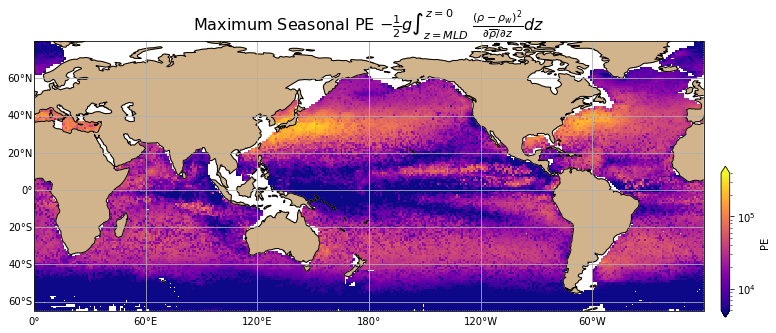

In [19]:
max_loc_pe = np.nan*np.ones((np.shape(pe_loc)[1], np.shape(pe_loc)[2]))
max_loc_pe_mo = np.nan*np.ones((np.shape(pe_loc)[1], np.shape(pe_loc)[2]))
for i in range(np.shape(pe_loc)[1]):
    for j in range(np.shape(pe_loc)[2]):
        max_loc_pe[i,j] = np.nanmax(pe_loc[:,i,j])
        if (~np.isnan(np.nanmax(pe_loc[:,i,j]))) & (np.nanmax(pe_loc[:,i,j]) > 0):
            max_loc_pe_mo[i,j] = np.where(pe_loc[:,i,j] == np.nanmax(pe_loc[:,i,j]))[0]
        
f, ax = plt.subplots(1,1,figsize=(12,7), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
arg_d = xr.DataArray(data=max_loc_pe, dims=['latitude', 'longitude'], coords=data_coords)
arg_d_p = arg_d.plot(ax=ax,transform=ccrs.PlateCarree(), norm=LogNorm(vmin=pe_levs[0], vmax=400000), \
                     cmap=plt.get_cmap('plasma'), zorder=0, add_colorbar=False)
# ax.contour(A_s.LONGITUDE.data,A_s.LATITUDE.data,np.nanmean(pe,axis=0),\
#            transform=ccrs.PlateCarree(),\
#            levels=np.arange(pe_levs[0],pe_levs[1],25000),linewidths=0.75,colors='w') # np.nanmean(pe,axis=0)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
ax.set_title(r'Maximum Seasonal PE $- \frac{1}{2} g \int_{z=MLD}^{z=0}$ $\frac{(\rho-\rho_{w})^2}{\partial \overline{\rho} / \partial z} dz$',fontsize=16)
cbpos = [0.92, 0.222, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_d_p, cax=cax, orientation='vertical', extend='both',label='PE')
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_07_23/argo_seasonal_frac_change.jpg', dpi=550)

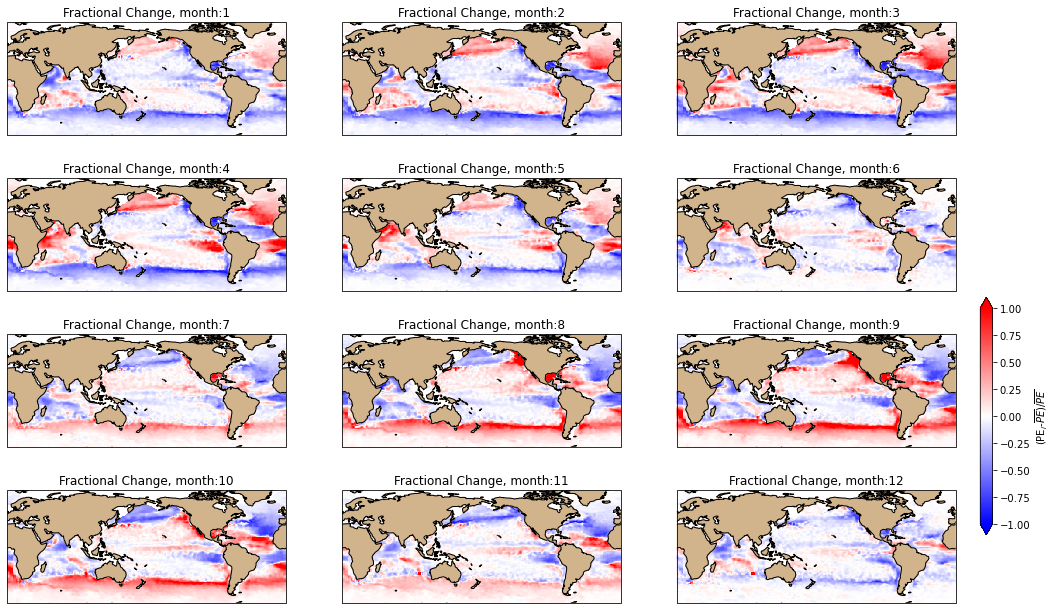

In [26]:
data_coords = {'latitude': A_s.LATITUDE.data, 'longitude': A_s.LONGITUDE.data}
tcmap_2 = plt.get_cmap('bwr')
f, ax = plt.subplots(4,3,figsize=(17,11), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
gax = ax.flatten()
for i in range(len(gax)):
    arg_d = xr.DataArray(data=(pe[i,:,:]-np.nanmean(pe,axis=0))/np.nanmean(pe,axis=0), \
                         dims=['latitude', 'longitude'], coords=data_coords)
    arg_d_p = arg_d.plot(ax=gax[i],transform=ccrs.PlateCarree(), vmin=-1, vmax=1, \
                     cmap=tcmap_2, zorder=0, add_colorbar=False)

    gax[i].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
    gax[i].coastlines()
    gax[i].set_title('Fractional Change, month:' + str(i+1))
cbpos = [0.92, 0.222, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_d_p, cax=cax, \
                orientation='vertical', extend='both', \
                label='(PE$_i$-$\overline{PE}$)/$\overline{PE}$') # 'density at ' + str(A_s.PRESSURE[this_p].data) + ' dbar'
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_07_23/argo_seasonal_pe.jpg', dpi=550)

In [ ]:
# ----- APE AND RATE OF CONVERSION TO EKE ------ 
# try estimate availbe potential energy 
# APE extracted from the mean state at rate = 
# dP/dt = - \int \int \int g*kGM*abs(hor grad rho)^2 / (drho/dz) dV 
# Vertical Eddy Energy Fluxes in the North Atlantic Subtropical and Subpolar Gyres, Zhai et. al 2013
g = 9.81
rho_0 = 1035
K = loadmat('/Users/jakesteinberg/Documents/CPT/Argo/WOA18_K_v2.mat')
K_lon = K['lon'][0]
K_lat = K['lat'][0]
K_dep = K['depth'][0]
K_K = K['K']
# align in lon, cut off in lat, interpolate to right depth 
iinn = np.where((K_lat >= np.nanmin(lat)) & (K_lat <= np.nanmax(lat)))[0]
K_K = K_K[:,iinn,:]
K_offset = np.where(K_lon >= lon[0])[0][0]
K_K = np.concatenate((K_K[K_offset:,:,:], K_K[0:K_offset,:,:]),axis=0)

In [10]:
# interpolate nans in mld (only for holte estimate )
from altimetry_tools import nan_helper, interp_nans
mldI = mld.copy()
for k in tqdm(range(np.shape(mld)[2])):
    for i in range(np.shape(mld)[0]):
        this_mld = mld[i,:,k]
        nans, x = nan_helper(this_mld)
        mldI[i,:,k] = interp_nans(this_mld, nans, x, 1)
    for j in range(np.shape(mld)[1]):
        this_mld = mldI[:,j,k]
        nans, x = nan_helper(this_mld)
        mldI[:,j,k] = interp_nans(this_mld, nans, x, 1)

287662
255933


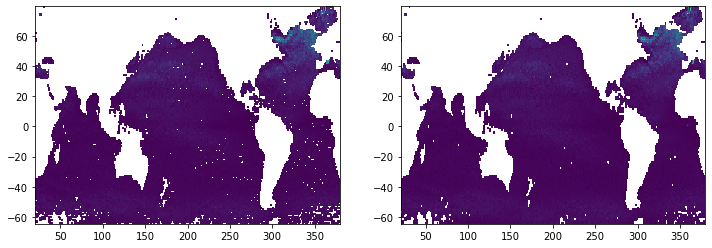

In [15]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.pcolor(lon,lat,mld[:,:,1])
ax2.pcolor(lon,lat,mldI[:,:,1])
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_09_23/mld_test.jpg', dpi=250)
print(np.sum(np.isnan(mld)))
print(np.sum(np.isnan(mldI)))

In [16]:
mean_den_r = np.nanmean(density,axis=0)
ape_rate = np.nan*np.ones((np.shape(density)[0], np.shape(density)[1], np.shape(density)[2]))
ape_rate_bfk = np.nan*np.ones(np.shape(ape_rate))
gradx = np.nan*np.ones(np.shape(ape_rate))
grady = np.nan*np.ones(np.shape(ape_rate))
estimate_depth = np.nan*np.ones(np.shape(ape_rate))
scale_factor = np.nan*np.ones(np.shape(ape_rate))
rho0 = 1025
for m in tqdm(range(np.shape(density)[0])): # MONTH
    for i in range(1,len(lat)-2): # LAT
        for j in range(1,len(lon)-2): # LON
            
            # --- drho_dz 
            # this_mean_den = density[m,i,j]
            # this_z = gsw.z_from_p(pressure,lat[i])
            # dz = (this_z[0:-1] - this_z[1:])
            # this_drhodz = (this_mean_den[0:-1] - this_mean_den[1:])/(this_z[0:-1]-this_z[1:])
            
            # --- drho_dx,drho_dy
            xx = 1852 * 60 * np.cos(np.deg2rad(lat[i])) * (lon[j-1:j+2] - lon[j])
            yy = 1852 * 60 * (lat[i-1:i+2] - lat[i])
            
            # -- if using mimoc, already have it at desired depth (skip )
            # this_dbdx = np.nan*np.ones(len(this_z))
            # this_dbdy = np.nan*np.ones(len(this_z))
            # for zi in range(len(this_z)):
            #     p1 = np.polyfit(yy, -9.81*(density[m, zi, i-1:i+2, j] - rho0)/rho0, 1)
            #     this_dbdy[zi] = p1[0]
            #     p2 = np.polyfit(xx, -9.81*(density[m, zi, i, j-1:j+2] - rho0)/rho0, 1)
            #     this_dbdx[zi] = p2[0]
            # # --- K at right depth 
            # this_z_2 = this_z[0:-1] - dz/2
            # this_gradx = np.interp(np.abs(this_z_2), np.abs(this_z), this_dbdx)
            # this_grady = np.interp(np.abs(this_z_2), np.abs(this_z), this_dbdy)
            # # pick a depth to extract rate for (currently at 24m)
            # d_in = 2
            # estimate_depth[m,i,j] = -1*this_z[d_in]
            # gradx[m,i,j] = this_gradx[d_in]
            # grady[m,i,j] = this_grady[d_in]
            
            # if using mimoc
            p1 = np.polyfit(yy, -9.81*((density[m, i-1:i+2, j]+1000) - rho0)/rho0, 1)
            this_dbdy = p1[0]
            p2 = np.polyfit(xx, -9.81*((density[m, i, j-1:j+2]+1000) - rho0)/rho0, 1)
            this_dbdx = p2[0]      
            gradx[m,i,j] = this_dbdx
            grady[m,i,j] = this_dbdy
            
            # interior - parameterized version 
            # this_K = np.interp(np.abs(this_z_2), K_dep[0:40], K_K[j,i,0:40])
            # this_K = 1000
            # ape_rate[m,i,j] = np.sum(-1*g*this_K*(this_gradx**2 + this_grady**2)/this_drhodz*dz)
            # from Takaya 2017 and Baylor 2008 (FOR THE MIXED LAYER)
            
            coriolis = 2*(7.27*10**(-5))*np.sin(np.deg2rad(lat[i]))
            grad_S = np.nanmax(yy) - np.nanmin(yy)
            L_f = (np.sqrt(gradx[m,i,j]**2 + grady[m,i,j]**2))*mld[m,i,j]/(coriolis**2)
            scale_factor[m,i,j] = grad_S / L_f
            ape_rate[m,i,j] = scale_factor[m,i,j]*(gradx[m,i,j]**2 + grady[m,i,j]**2)*(mld[m,i,j]**2)/np.abs(coriolis) 

            # np.sum(-1*g*this_K*(np.abs(this_gradx+this_grady)**2)/this_drhodz*dz)
            # C = 2
            # omega = 7.292115*10**(-5) # rad/s 
            # f_ref = 2*omega*np.sin(np.deg2rad(lat[i]))
            # H = mld[i,j,m]
            # this_by = np.nan*np.ones(len(this_z))
            # this_bx = np.nan*np.ones(len(this_z))
            # for zi in range(len(this_z)):
            #     p1 = np.polyfit(yy, -g*(1000+density[m, zi, i-3:i+4, j])/rho_0, 1)
            #     this_by[zi] = p1[0]
            #     p2 = np.polyfit(xx, -g*(1000+density[m, zi, i, j-3:j+4])/rho_0, 1)
            #     this_bx[zi] = p2[0]
            # b_y = np.nanmean(this_by)
            # b_x = np.nanmean(this_bx)
            # ape_rate_bfk[m,i,j] = H*()

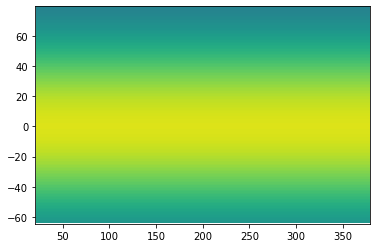

In [23]:
f, ax = plt.subplots(1,1,figsize=(6,4))
ax.pcolor(lon, lat, np.nanmean(estimate_depth,axis=0),vmin=19.7,vmax=19.9)

(-2.0, 5.0)

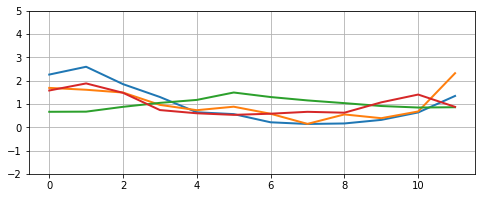

In [17]:
t_lat = [25.5, 35.5, -20.5, 30.5]
t_lon = [150.5, 215.5, 90.5, 310.5]
f, ax = plt.subplots(1,1,figsize=(8,3))
for i in range(len(t_lat)):
    ax.plot(np.arange(12), ape_rate[:, np.where((lat > (t_lat[i]-0.5)) & (lat < (t_lat[i]+0.5)))[0][0], \
                     np.where((lon > (t_lon[i]-0.5)) & (lon < (t_lon[i]+0.5)))[0][0]]/ \
                     np.nanmean(ape_rate[:, np.where((lat > (t_lat[i]-0.5)) & (lat < (t_lat[i]+0.5)))[0][0], \
                     np.where((lon > (t_lon[i]-0.5)) & (lon < (t_lon[i]+0.5)))[0][0]]),linewidth=2)
ax.grid()
ax.set_ylim([-2, 5])

In [13]:
np.nanmin(ape_rate)

2.430334008271552e-09

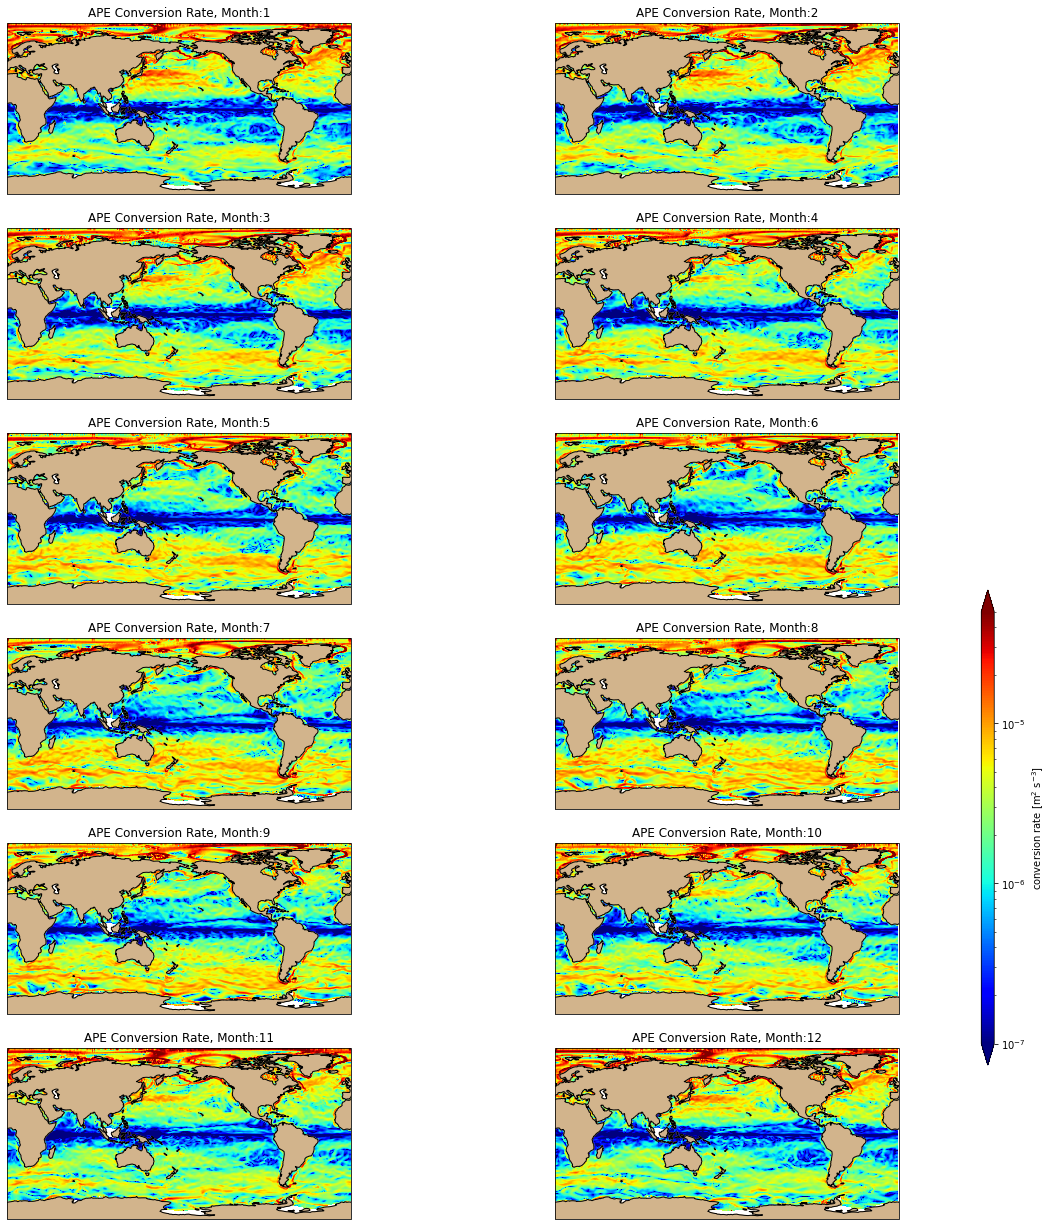

In [18]:
clims = [1e-7, 5e-5] # [1e-10, 1e-7] # old gradient [2e-16, 2e-12]
data_coords = {'latitude': lat, 'longitude': lon}
tcmap_2 = plt.get_cmap('jet')
f, ax = plt.subplots(6,2,figsize=(18,22), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
gax = ax.flatten()
for i in range(len(gax)):
    # grad_test = gradx[i,:,:]**2 + grady[i,:,:]**2
    arg_d = xr.DataArray(data=ape_rate[i,:,:], dims=['latitude', 'longitude'], coords=data_coords) # ape_rate[i,:,:]
    arg_d_p = arg_d.plot(ax=gax[i],transform=ccrs.PlateCarree(), norm=LogNorm(vmin=clims[0], vmax=clims[1]), \
                     cmap=tcmap_2, zorder=0, add_colorbar=False) # norm=LogNorm(vmin=0.000001, vmax=0.005)
    gax[i].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
    gax[i].coastlines()
    gax[i].set_title('APE Conversion Rate, Month:' + str(i+1))
cbpos = [0.92, 0.222, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_d_p, cax=cax, orientation='vertical', extend='both', \
                label='conversion rate [m$^2$ s$^{-3}$]') # 'density at ' + str(A_s.PRESSURE[this_p].data) + ' dbar'
# f.savefig('/Users/jakesteinberg/Desktop/cpt_manuscript_figures/r2/pe_conversions/pe_conversion_rate_2Deg_w_sf.jpg', dpi=250)

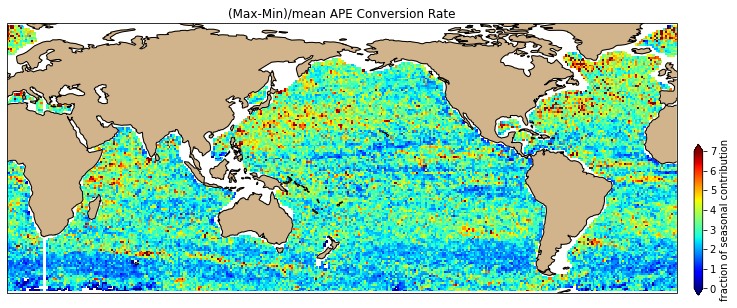

In [268]:
f, ax = plt.subplots(1,1,figsize=(12,7), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
arg_d = xr.DataArray(data=(np.nanmax(ape_rate,axis=0) - np.nanmin(ape_rate,axis=0))/np.nanmean(ape_rate,axis=0), \
                     dims=['latitude', 'longitude'], coords=data_coords)
arg_d_p = arg_d.plot(ax=ax,transform=ccrs.PlateCarree(), vmin=0, vmax=7, \
                     cmap=plt.get_cmap('jet'), zorder=0, add_colorbar=False)
# arg_d_p = arg_d.plot.contour(ax=ax,transform=ccrs.PlateCarree(), levels=[0.00002, 0.00008], \
#                      colors='k',linewidths=3, zorder=0, add_colorbar=False)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines()
ax.set_title('(Max-Min)/mean APE Conversion Rate')
cbpos = [0.92, 0.23, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_d_p, cax=cax, orientation='vertical', extend='both', \
                label='fraction of seasonal contribution')
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_09_23/ape_conversion_rate_max_2Deg.jpg', dpi=300)

In [11]:
ape_rate_max_month = np.nan*np.ones((np.shape(ape_rate)[1], np.shape(ape_rate)[2]))
ape_rate_max_month_i = np.nan*np.ones((np.shape(ape_rate)[1], np.shape(ape_rate)[2]))
for i in tqdm(range(np.shape(ape_rate)[1])):
    for j in range(np.shape(ape_rate)[2]):
        ape_rate_max_month[i,j] = np.nanmax(ape_rate[:,i,j])
        if np.nansum(ape_rate[:,i,j] < 4):
            ape_rate_max_month_i[i,j] = np.where(ape_rate[:,i,j] == np.nanmax(ape_rate[:,i,j]))[0]
    

NameError: name 'ape_rate' is not defined

In [195]:
mld_max_month = np.nan*np.ones((np.shape(mld)[0], np.shape(mld)[1]))
for i in tqdm(range(np.shape(mld)[0])):
    for j in range(np.shape(mld)[1]):
        if np.nansum(np.isnan(mld[i,j,:])) < 4:
            mld_max_month[i,j] = np.where(mld[i,j,:] == np.nanmax(mld[i,j,:]))[0]

In [31]:
argo_t.ARGO_TEMPERATURE_MEAN[0]

<xarray.DataArray 'ARGO_TEMPERATURE_MEAN' (LATITUDE: 145, LONGITUDE: 360)>
array([[-1.115, -1.109, -1.121, ..., -1.181, -1.159, -1.13 ],
       [-1.046, -1.044, -1.033, ..., -1.074, -1.064, -1.054],
       [-0.978, -0.965, -0.958, ..., -1.027, -1.017, -1.   ],
       ...,
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan]], dtype=float32)
Coordinates:
  * LONGITUDE  (LONGITUDE) float32 20.5 21.5 22.5 23.5 ... 377.5 378.5 379.5
  * LATITUDE   (LATITUDE) float32 -64.5 -63.5 -62.5 -61.5 ... 77.5 78.5 79.5
    PRESSURE   float32 2.5
Attributes:
    units:      degree celcius (ITS-90)
    long_name:  ARGO TEMPERATURE MEAN Jan 2004 - Dec 2018 (15.0 year) RG CLIM...

Text(0, 70, 'b)')

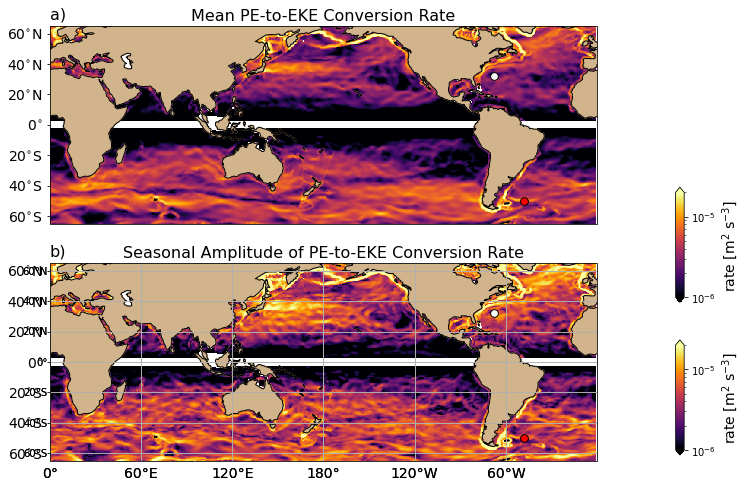

In [24]:
pmin=1e-6
pmax=2e-5
colors = ['#086788', '#F0C808', '#79B791', '#DC493A', 'c', 'm', '#FF8C00'] # #664147
order = ['Eastern N. Pac.', 'Kuroshio', 'Indian', 'N. Atl.', 'ACC', 'Gulf Stream','Eastern S. Pac.']
location = np.array([[210, 214, 35, 39], [148, 152, 28, 32], [90, 94, -21, -17], \
                     [326, 330, 38, 42], [310, 314, -52, -48], [290, 294, 30, 34], [248, 252, -40, -36]])
# -- kuroshio
t_lat = np.nanmean(location[5,2:])
t_lon = np.nanmean(location[5,0:2])
# -- site 2 
t_lat_2 = np.nanmean(location[4,2:])
t_lon_2 = np.nanmean(location[4,0:2])
# -- site 3 
t_lat_3 = 40.5
t_lon_3 = 330.5 

tl1 = 18
tl2 = 20

pecmap = plt.get_cmap('inferno')
# FIGURE  (map of seasonal change in APE rate)
f, (ax0,ax1) = plt.subplots(2,1,figsize=(12,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
data_coords = {'latitude': lat, 'longitude': lon}

# -- (mean) conversion rate  
ape_rate_plot = np.nanmean(ape_rate,axis=0)
eq_lat = np.where((lat < 3) & (lat > -3))[0]
ape_rate_plot[eq_lat,:] = np.nan
rate_coords = {'latitude': lat, 'longitude': lon} # [25:-11]
rate_xr = xr.DataArray(data=ape_rate_plot, \
                       dims=['latitude', 'longitude'], coords=rate_coords) # [25:-11,:]+1
rate_xr = rate_xr.plot(ax=ax0,transform=ccrs.PlateCarree(), norm=LogNorm(vmin=pmin, vmax=pmax), \
                     cmap=pecmap, zorder=0, add_colorbar=False)
# argo_t.ARGO_TEMPERATURE_MEAN[0].plot.contour(ax=ax0, \
#                                              transform=ccrs.PlateCarree(),levels=[tl1, tl2], colors='w')
ax0.scatter(t_lon, t_lat, s=60, color='w', transform=ccrs.PlateCarree(),zorder=2,edgecolors='k')
ax0.scatter(t_lon_2, t_lat_2, s=60, color='r', transform=ccrs.PlateCarree(),zorder=2,edgecolors='k')
ax0.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax0.coastlines()
ax0.set_ylim([-65,65])
gl = ax1.gridlines(draw_labels=True)
ax0.set_title('Mean PE-to-EKE Conversion Rate',fontsize=16)
gl.xlabels_top = False
# gl.xlabels_bottom = False
cbpos = [0.92, 0.4, 0.01, 0.2]
cax = f.add_axes(cbpos)
cb = f.colorbar(rate_xr, cax=cax, orientation='vertical', extend='both') # ticks=np.arange(1,13)+0.5
cb.set_label(label='rate [m$^2$ s$^{-3}$]', fontsize=14)
# cb.ax.set_yticklabels(np.arange(1,13), fontsize=12)
gl.ylabels_left = True
gl.xlabel_style = {'fontsize': 14}

# -- (max - min) conversion rate  
ape_rate_plot_2 = np.nanmax(ape_rate,axis=0) - np.nanmin(ape_rate,axis=0)
eq_lat = np.where((lat < 3) & (lat > -3))[0]
ape_rate_plot_2[eq_lat,:] = np.nan
rate_coords = {'latitude': lat, 'longitude': lon} # [25:-11]
rate_xr = xr.DataArray(data=ape_rate_plot_2, \
                       dims=['latitude', 'longitude'], coords=rate_coords) # [25:-11,:]+1
rate_xr = rate_xr.plot(ax=ax1,transform=ccrs.PlateCarree(), norm=LogNorm(vmin=pmin, vmax=pmax), \
                     cmap=pecmap, zorder=0, add_colorbar=False)
# argo_t.ARGO_TEMPERATURE_MEAN[0].plot.contour(ax=ax1, \
#                                              transform=ccrs.PlateCarree(),levels=[tl1, tl2], colors='w')
ax1.scatter(t_lon, t_lat, s=60, color='w', transform=ccrs.PlateCarree(),zorder=2,edgecolors='k')
ax1.scatter(t_lon_2, t_lat_2, s=60, color='r', transform=ccrs.PlateCarree(),zorder=2,edgecolors='k')
ax1.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax1.coastlines()
ax1.set_ylim([-65,65])
gl = ax1.gridlines(draw_labels=True)
ax1.set_title('Seasonal Amplitude of PE-to-EKE Conversion Rate',fontsize=16)
gl.xlabels_top = False
# gl.xlabels_bottom = False
cbpos = [0.92, 0.135, 0.01, 0.2]
cax = f.add_axes(cbpos)
cb = f.colorbar(rate_xr, cax=cax, orientation='vertical', extend='both') # ticks=np.arange(1,13)+0.5
cb.set_label(label='rate [m$^2$ s$^{-3}$]', fontsize=14)
# cb.ax.set_yticklabels(np.arange(1,13), fontsize=12)
gl.ylabels_left = True
gl.xlabel_style = {'fontsize': 14}

# -- (map of max seasonal loc PE)
# pe_levs = [5000, 200000] # 250000
# arg_d = xr.DataArray(data=np.nanmax(pe_loc,axis=0), dims=['latitude', 'longitude'], coords=data_coords)
# arg_d_p = arg_d.plot(ax=ax2,transform=ccrs.PlateCarree(), norm=LogNorm(vmin=pe_levs[0], vmax=pe_levs[1]), \
#                      cmap=pecmap, zorder=0, add_colorbar=False)
# argo_t.ARGO_TEMPERATURE_MEAN[0].plot.contour(ax=ax2, \
#                                              transform=ccrs.PlateCarree(),levels=[tl1, tl2], colors='w')
# ax2.scatter(t_lon, t_lat, s=60, color='w', transform=ccrs.PlateCarree(),zorder=3,edgecolors='k')
# ax2.scatter(t_lon_2, t_lat_2, s=60, color='r', transform=ccrs.PlateCarree(), zorder=3,edgecolors='k')
# ax2.set_ylim([-65,65])
# ax2.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
# ax2.coastlines()
# gl = ax2.gridlines(draw_labels=True)
# ax2.set_title('Seasonal Amplitude (max - min) of Mixed Layer PE', fontsize=16)
# gl.xlabels_top = False
# cbpos = [0.92, 0.66, 0.01, 0.2]
# cax = f.add_axes(cbpos)
# cb = f.colorbar(arg_d_p, cax=cax, orientation='vertical', extend='both')
# cb.set_label(label='PE [J m$^{-2}$]', fontsize=14) # [kg m$^2$$s^{-2}$]
# ax2.set_yticks([-60, -40, -20, 0, 20, 40, 60])
# ax2.set_yticklabels(['60$^{\circ}$S', '40$^{\circ}$S', '20$^{\circ}$S', '0$^{\circ}$', '20$^{\circ}$N', '40$^{\circ}$N', '60$^{\circ}$N'],fontsize=14)

ax0.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax0.set_yticklabels(['60$^{\circ}$S', '40$^{\circ}$S', '20$^{\circ}$S', '0$^{\circ}$', '20$^{\circ}$N', '40$^{\circ}$N', '60$^{\circ}$N'],fontsize=14)
ax1.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax1.set_yticklabels(['60$^{\circ}$S', '40$^{\circ}$S', '20$^{\circ}$S', '0$^{\circ}$', '20$^{\circ}$N', '40$^{\circ}$N', '60$^{\circ}$N'],fontsize=14)
ax1.set_ylabel('')
ax0.set_ylabel('')
# ax2.set_ylabel('')
gl.xlabel_style = {'fontsize': 14}
# ax2.text(0, 70, 'a)', fontsize=16, transform=ccrs.PlateCarree())
ax0.text(0, 70, 'a)', fontsize=16, transform=ccrs.PlateCarree())
ax1.text(0, 70, 'b)', fontsize=16, transform=ccrs.PlateCarree())
# ax0.text(0, 90, 'c)', fontsize=14, transform=ccrs.PlateCarree())
# f.savefig('/Users/jakesteinberg/Desktop/cpt_manuscript_figures/r2/argo_pe_rate.jpg', dpi=350)

In [131]:
# load file 
filename = ('/Users/jakesteinberg/Documents/CPT/j2_filtered.nc')
j2_filtered = xr.open_dataset(filename)
total_ke = j2_filtered['total_ke'].data
ke_lat = j2_filtered['latitude'].data
ke_lon = j2_filtered['longitude'].data

# month to compare KE to 'converted' KE 
moc = 1
mean_ke = np.transpose(total_ke[moc,:,:]) # np.transpose(np.nanmean(total_ke,axis=0))

# need to shift/re-set longitudes 
[ii, ai, bi] = np.intersect1d(lat,ke_lat[1:-1],return_indices=True)
mean_pe_r = ape_rate[moc,:,:] # np.nanmean(ape_rate,axis=0)
r1 = np.where(lon > 360)[0]
pe_ra = np.concatenate((mean_pe_r[:,r1], mean_pe_r[:,0:r1[0]]),axis=1)

Text(0.5, 1.0, 'Conversion Rate / total KE [month=2]')

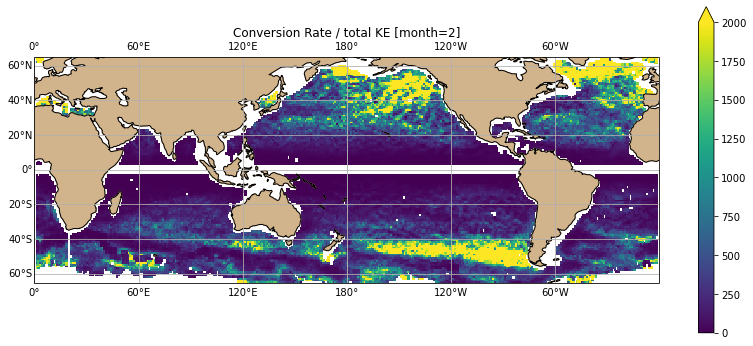

In [141]:
f, ax = plt.subplots(1,1,figsize=(14,6),subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
# ax.pcolor(ke_lon, ke_lat[bi], (pe_ra[ai,:]*(60*60*24*30))/mean_ke[bi,:], vmin=0,vmax=3)
data_coords = {'latitude': ke_lat[bi], 'longitude': ke_lon}
pe_ke_comp = xr.DataArray(data=(pe_ra[ai,:]*(60*60*24*15))/mean_ke[bi,:], dims=['latitude', 'longitude'], coords=data_coords)
pe_ke_comp.plot(ax=ax,transform=ccrs.PlateCarree(), vmin=0, vmax=2000, add_colorbar=True)
ax.set_ylim([-65,65])
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
ax.set_title('Conversion Rate / total KE [month='+str(moc + 1)+']')
# f.savefig('/Users/jakesteinberg/Desktop/cpt_manuscript_figures/r2/pe_conversions/conversion_ke_frac_2.jpg', dpi=200)

In [52]:
np.shape(ape_rate)

(12, 145, 360)

NameError: name 'pressure' is not defined

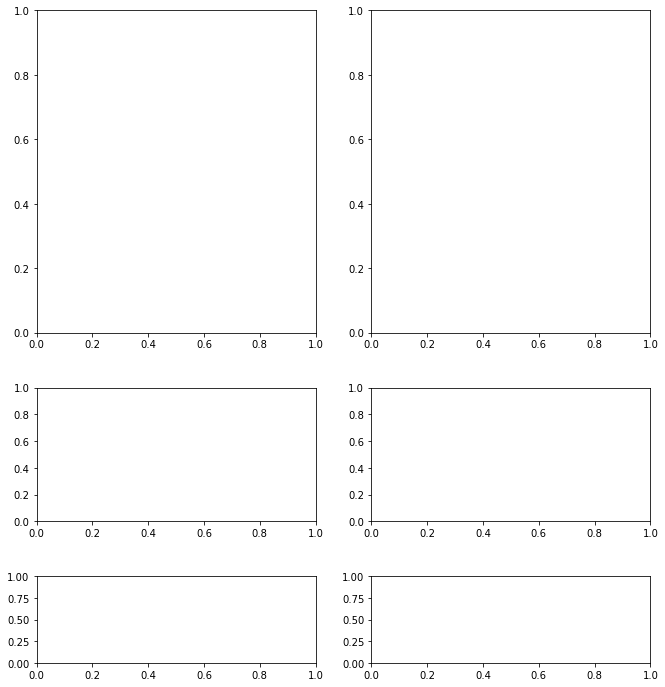

In [25]:
colors = ['#086788', '#F0C808', '#79B791', '#DC493A', 'c', 'm', '#FF8C00'] # #664147
order = ['Eastern N. Pac.', 'Kuroshio', 'Indian', 'N. Atl.', 'ACC', 'Gulf Stream','Eastern S. Pac.']
location = np.array([[210, 214, 35, 39], [148, 152, 28, 32], [90, 94, -21, -17], \
                     [326, 330, 38, 42], [310, 314, -54, -50], [290, 294, 30, 34], [248, 252, -40, -36]])
# -- kuroshio
t_lat = np.nanmean(location[5,2:])
t_lon = np.nanmean(location[5,0:2])
# -- site 2 
t_lat_2 = np.nanmean(location[4,2:])
t_lon_2 = np.nanmean(location[4,0:2])
# -- site 3 
t_lat_3 = 40.5
t_lon_3 = 330.5 

data_coords = {'latitude': lat, 'longitude': lon}
pe_levs = [5000, 250000] # 250000
c_eta = plt.get_cmap('hsv',12)
lmo = ['Jan.' , 'Feb.', 'Mar.', 'Apr.', 'May', 'Jun.', 'Jul.', 'Aug.', 'Sep.', 'Oct.', 'Nov.', 'Dec.']

# f, (ax,ax2) = plt.subplots(1,2,figsize=(8,7))
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(11, 12))
gs = GridSpec(14, 2, figure=fig)
ax = fig.add_subplot(gs[0:7, 0])
ax2 = fig.add_subplot(gs[0:7, 1])
ax3 = fig.add_subplot(gs[8:11, 0])
ax4 = fig.add_subplot(gs[8:11, 1])
ax5 = fig.add_subplot(gs[12:, 0])
ax6 = fig.add_subplot(gs[12:, 1])

# -- 1 -- 
this_z = gsw.z_from_p(pressure,t_lat)
this_lon = np.where((A_lon > (t_lon-2)) & (A_lon < (t_lon+2)))[0][1]
this_lat = np.where((A_lat > (t_lat-2)) & (A_lat < (t_lat+2)))[0][1]
count = 0
for i in [7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 6]:
    ax.plot(density[i, :, this_lat, this_lon]+1000, this_z[0:how_deep], color=c_eta(count),zorder=0, \
            linewidth=2, label=lmo[i])
    int_z = -1*mld[this_lat,this_lon,i]
    deep = np.where(this_z <= int_z)[0]
    if len(deep) > 0:
        ax.scatter(density[i, deep[0], this_lat, this_lon]+1000,this_z[deep[0]],s=30,color=c_eta(count),zorder=2)
    if mld[this_lat, this_lon,i] == np.nanmax(mld[this_lat, this_lon,:]):
        ax.plot(density[i, :, this_lat, this_lon]+1000,this_z,color='k',zorder=2,linestyle='--')
        ax.scatter(density[i, deep[0], this_lat, this_lon]+1000,this_z[deep[0]],s=75,color='k',zorder=2,marker='s')
    count = count + 1

ax.set_ylabel('z [m]', fontsize=16)
ax.set_xlabel(r'$\rho_{\theta}$ [kg m $^{-3}$]',fontsize=14)
ax.set_title('[' + str(t_lon)+'$^{\circ}$E, ' + str(t_lat) + '$^{\circ}$N]', fontsize=15)
ax.legend(loc='lower left')
# -- 2 -- 
this_z = gsw.z_from_p(pressure,t_lat_2)
this_lon2 = np.where((A_lon > (t_lon_2-2)) & (A_lon < (t_lon_2+2)))[0][2]
this_lat2 = np.where((A_lat > (t_lat_2-2)) & (A_lat < (t_lat_2+2)))[0][2]
count = 0
for i in [7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 6]:
    ax2.plot(density[i, :, this_lat2, this_lon2]+1000, this_z[0:how_deep], color=c_eta(count),zorder=0, linewidth=2)
    int_z = -1*mld[this_lat2,this_lon2,i]
    deep = np.where(this_z <= int_z)[0]
    if len(deep) > 0:
        ax2.scatter(density[i, deep[0], this_lat2, this_lon2]+1000,this_z[deep[0]],s=30, color=c_eta(count),zorder=2) # int_z
    if mld[this_lat2, this_lon2, i] == np.nanmax(mld[this_lat2, this_lon2, :]):
        ax2.plot(density[i, :, this_lat2, this_lon2]+1000, this_z,color='k',zorder=2,linestyle='--')
        ax2.scatter(density[i, deep[0], this_lat2, this_lon2]+1000,this_z[deep[0]],s=75,color='k',zorder=2,marker='s')
    count = count + 1
ax2.set_xlabel(r'$\rho_{\theta}$ [kg m $^{-3}$]',fontsize=14)
if t_lat_2 < 0:
    ax2.set_title('[' + str(t_lon_2)+'$^{\circ}$E, ' + str(-1*t_lat_2) + '$^{\circ}$S]', fontsize=15)
else:
    ax2.set_title('[' + str(t_lon_2)+'$^{\circ}$E, ' + str(t_lat_2) + '$^{\circ}$N]', fontsize=15)

# -- 3 -- 
ax3.plot([0,13],[0, 0], color='#808080', linewidth=1.5)
ax3.plot(np.arange(1,13), ape_rate[:, this_lat, this_lon], color='k',linewidth=3,label='PE-to-EKE')

ax3_2=ax3.twinx()
ax3_2.plot(np.arange(1,13), (gradx[:,this_lat,this_lon]**2 + grady[:,this_lat,this_lon]**2), \
           color='#DB7093',linestyle='-',label=r'$\nabla b$')
# ax3_2.set_yticks(np.arange(0,150,25))
# ax3_2.set_yticklabels(['0','25','50','75','100','125'])
# ax3_2.invert_yaxis()
ax3.set_xticks(np.arange(1,13))
ax3.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax3.set_xlim([1,12])
ax3_2.tick_params(axis='y', colors='#DB7093')
ax3.set_ylabel(r'PE-to-EKE [m$^2$ s$^{-3}$]',fontsize=12)
ax3.grid()
# -- 4 -- 
ax4.plot([0,13],[0, 0], color='#808080', linewidth=1.5)
ax4.plot(np.arange(1,13), ape_rate[:, this_lat2, this_lon2], color='k',linewidth=3)
ax4_2 = ax4.twinx()
ax4_2.plot(np.arange(1,13), (gradx[:,this_lat2,this_lon2]**2 + grady[:,this_lat2,this_lon2]**2), \
           color='#DB7093',linestyle='-')
ax4_2.tick_params(axis='y', colors='#DB7093')
ax4_2.set_ylabel(r'$ \left( \frac{\partial b}{\partial x} \right) ^2 + \left( \frac{\partial b}{\partial y} \right) ^2$ [$s^{-4}$]', \
                 color='#DB7093', fontsize=15)
ax4.set_xticks(np.arange(1,13))
ax4.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax4.set_xlim([1,12])
ax4.grid()

pe_offset = np.nanmax(pe_loc[:, this_lat, this_lon])
# -- 5 -- 
ax5.plot(np.arange(1,13), -1*(pe_loc[:, this_lat, this_lon]) + pe_offset,color='#6B8E23',linewidth=3,label='PE')
ax5_2=ax5.twinx()
ax5_2.plot(np.arange(1,13), mldI[this_lat, this_lon, :],color='#B8860B',linewidth=2)
ax5_2.set_ylim([0,250])
ax5_2.set_yticks(np.arange(0,250,50))
ax5_2.set_yticklabels(['','','','','',''])
ax5_2.tick_params(axis='y', colors='#B8860B')
ax5.set_ylabel(r'PE [kg m$^2$ s$^{-2}$]',fontsize=12)
ax5.set_xticks(np.arange(1,13))
ax5.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax5.grid()
ax5.set_xlim([1,12])
         
pe_offset = np.nanmax(pe_loc[:, this_lat2, this_lon2])
# -- 6 -- 
ax6.plot(np.arange(1,13), -1*(pe_loc[:, this_lat2, this_lon2]) + pe_offset,color='#6B8E23',linewidth=3)

ax6_2=ax6.twinx()
ax6_2.plot(np.arange(1,13), mldI[this_lat2, this_lon2, :],color='#B8860B',linewidth=2)
ax6_2.set_ylim([0,250])
ax6_2.set_yticks(np.arange(0,250,50))
ax6_2.set_yticklabels(['0','50','100','150','200'])
ax6_2.tick_params(axis='y', colors='#B8860B')
ax6_2.set_ylabel('mixed layer depth [m]',color='#B8860B', fontsize=12)
# ax4_2.invert_yaxis()
ax6.set_xticks(np.arange(1,13))
ax6.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax6.grid()
ax6.set_xlim([1,12])

ax.text(1023.2, 10, 'a)', fontsize=14,fontweight='bold')
ax2.text(1024.2, 10, 'b)', fontsize=14,fontweight='bold')
ax3.text(0.1,2.2e-5, 'c)', fontsize=14,fontweight='bold')
ax4.text(0.1,2.2e-5, 'd)', fontsize=14,fontweight='bold')
ax5.text(0.1, 120000, 'e)', fontsize=14,fontweight='bold')
ax6.text(0.1, 120000, 'f)', fontsize=14,fontweight='bold')
ax.grid()
ax2.grid()
ax.set_ylim([-250, 0])
ax.set_xlim([1023.5, 1026.5])
ax2.set_ylim([-250, 0])
ax2.set_xlim([1024.5, 1027.5])
ax3.set_ylim([0,2e-5])
ax4.set_ylim([0,2e-5])
# ax5.set_yscale('log')
# ax6.set_yscale('log')
ax5.set_ylim([10,100000])
ax6.set_ylim([10,100000])
ax3_2.set_ylim([0,2e-16])
ax4_2.set_ylim([0,2e-16])
# fig.savefig('/Users/jakesteinberg/Desktop/cpt_manuscript_figures/r2/mld_profs.jpg', dpi=300)

In [27]:
# save file 
# -------------------------------
filename = ('/Users/jakesteinberg/Documents/CPT/Argo/Argo_PE_APEConversion6.nc')
ds = xr.Dataset(
    data_vars=dict(
        # pe=(["month","lat","lon"], pe_loc),
        ape_rate=(["month","lat","lon"], ape_rate),
    ),
    coords=dict(
        month=(["month"], np.arange(0,12,1)),
        latitude=(["lat"], lat),
        longitude=(["lon"], lon),
    ),
)
ds.to_netcdf(path=filename)

In [300]:
# seasonal swing
ape_frac_change = np.nan*np.ones((len(lat),len(lon)))
ape_tot_change = np.nan*np.ones((len(lat),len(lon)))
for i in tqdm(range(len(lat))):        
    for j in range(len(lon)): 
        # if np.nanmean(pe[:,i,j]) > 0.25*np.nanmean(pe):
        ape_tot_change[i,j] = np.abs((np.nanmax(ape_rate[:,i,j]) - np.nanmin(ape_rate[:,i,j]))) 
        ape_frac_change[i,j] = np.abs((np.nanmax(ape_rate[:,i,j]) - \
                                       np.nanmin(ape_rate[:,i,j])))/np.abs(np.nanmean(ape_rate[:,i,j]))

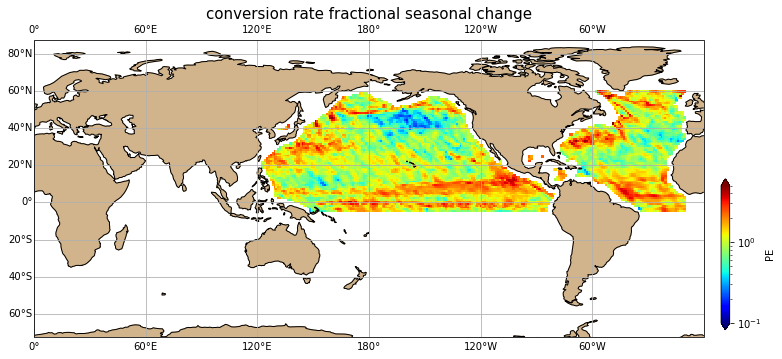

In [320]:
ape_p = ape_frac_change # *np.nanmean(ape_rate,axis=0)
# pmin = 0.00001
# pmax = 0.004
pmin=0.1
pmax=5
f, ax = plt.subplots(1,1,figsize=(12,7), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
arg_d = xr.DataArray(data=ape_p, dims=['latitude', 'longitude'], coords=data_coords)
arg_d_p = arg_d.plot(ax=ax,transform=ccrs.PlateCarree(), norm=LogNorm(vmin=pmin, vmax=pmax), \
                     cmap=plt.get_cmap('jet'), zorder=0, add_colorbar=False)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_title('conversion rate fractional seasonal change',fontsize=15)
cbpos = [0.92, 0.222, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_d_p, cax=cax, orientation='vertical', extend='both', label='PE')

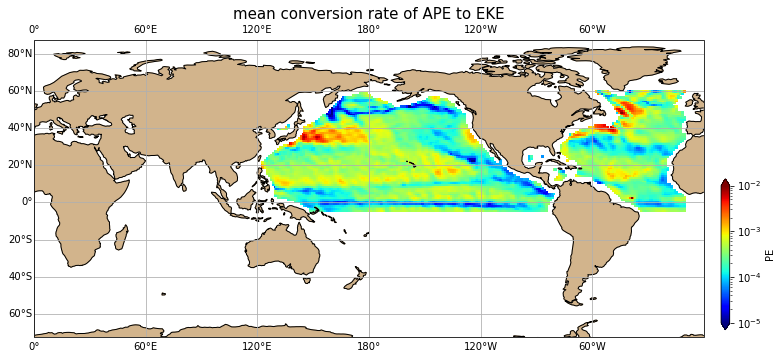

In [319]:
ape_p = np.nanmean(ape_rate,axis=0) # *np.nanmean(ape_rate,axis=0)
# pmin = 0.00001
# pmax = 0.004
pmin=0.1
pmax=5
f, ax = plt.subplots(1,1,figsize=(12,7), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
arg_d = xr.DataArray(data=ape_p, dims=['latitude', 'longitude'], coords=data_coords)
arg_d_p = arg_d.plot(ax=ax,transform=ccrs.PlateCarree(), norm=LogNorm(vmin=0.00001, vmax=0.01), \
                     cmap=plt.get_cmap('jet'), zorder=0, add_colorbar=False)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_title('mean conversion rate of APE to EKE',fontsize=15)
cbpos = [0.92, 0.222, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_d_p, cax=cax, orientation='vertical', extend='both', label='PE')

In [69]:
np.interp?

In [70]:
np.polyfit?

In [29]:
filename = ('/Users/jakesteinberg/Documents/CPT/spatial_filtering/aviso_ke_2.nc')
aviso = xr.open_dataset(filename)

In [30]:
aviso

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440)
Coordinates:
    crs        int32 ...
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875
    time       datetime64[ns] ...
Data variables:
    ugos       (latitude, longitude) float64 ...